In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scripts.data_loader import load_table

In [ ]:
daily_prices_df = pd.read_sql("SELECT * FROM daily_prices", conn)
securities_df = pd.read_sql("SELECT * FROM securities", conn)
fundamentals_df = pd.read_sql("SELECT * FROM fundamentals", conn)
daily_adjusted_prices_df = pd.read_sql("SELECT * FROM daily_adjusted_prices", conn)

# ***EDA***

In [ ]:
def eda(df, name):
    print(f"\n ----EDA for '{name}'----")
    print("Shape :", df.shape) # Shape
    print("Columns :", df.columns.tolist()) # All columns list
    print("\nData types :\n", df.dtypes) # Data types of all columns
    print("\nMissing values :", df.isnull().sum()) # of Number Missing Values
    print("\nNumber of Duplicates : ", daily_prices_df.duplicated().sum()) # Number of Duplicates

###***'daily_prices' Table***
As-in daily prices. Most of data spans from 2010 to the end 2016, for companies new on stock market date range is shorter.

In [25]:
eda(daily_prices_df, 'daily_prices')


 ----EDA for 'daily_prices'----
Shape : (334445, 7)
Columns : ['date', 'symbol', 'open', 'close', 'low', 'high', 'volume']

Data types :
 date       object
symbol     object
open      float64
close     float64
low       float64
high      float64
volume    float64
dtype: object

Missing values : date      0
symbol    0
open      0
close     0
low       0
high      0
volume    1
dtype: int64

Number of Duplicates :  0


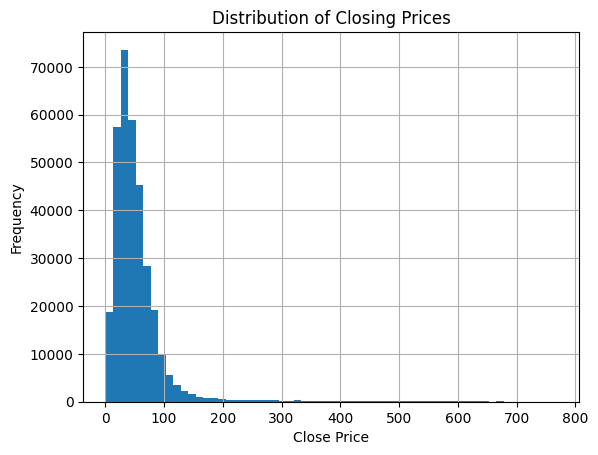

In [26]:
# Distribution of Closing Prices
daily_prices_df['close'].hist(bins=60)
plt.title('Distribution of Closing Prices')
plt.xlabel('Close Price')
plt.ylabel('Frequency')
plt.show()

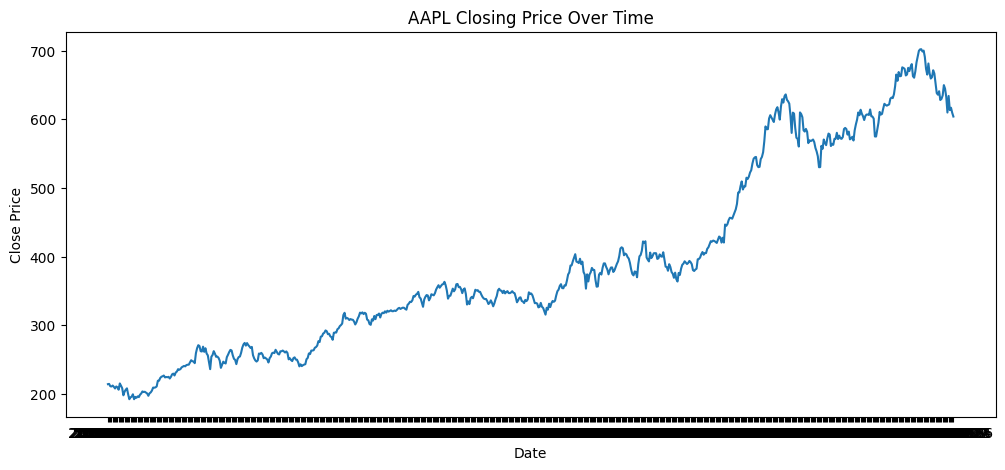

In [27]:
# Closing Price vs Time of a major sample Ticker
sample_ticker = 'AAPL'
aapl = daily_prices_df[daily_prices_df['symbol'] == sample_ticker]
plt.figure(figsize=(12, 5))
plt.plot(aapl['date'], aapl['close'])
plt.title(f'{sample_ticker} Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

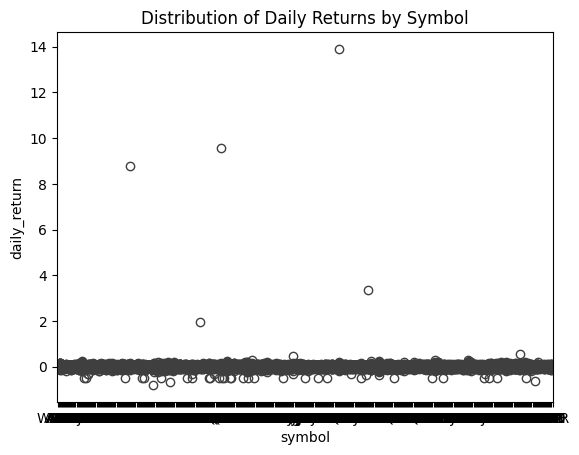

In [28]:
# Boxplot for Distribution of daily returns for selected stocks
daily_prices_df['daily_return'] = daily_prices_df.groupby('symbol')['close'].pct_change()
sns.boxplot(data=daily_prices_df, x='symbol', y='daily_return')
plt.title('Distribution of Daily Returns by Symbol')
plt.show()

*There are only **5 outliers** in the table as seen in the boxplot.
We **don't need to remove** them as they are **part of real market** behavior and they'll be useful in the model training.*

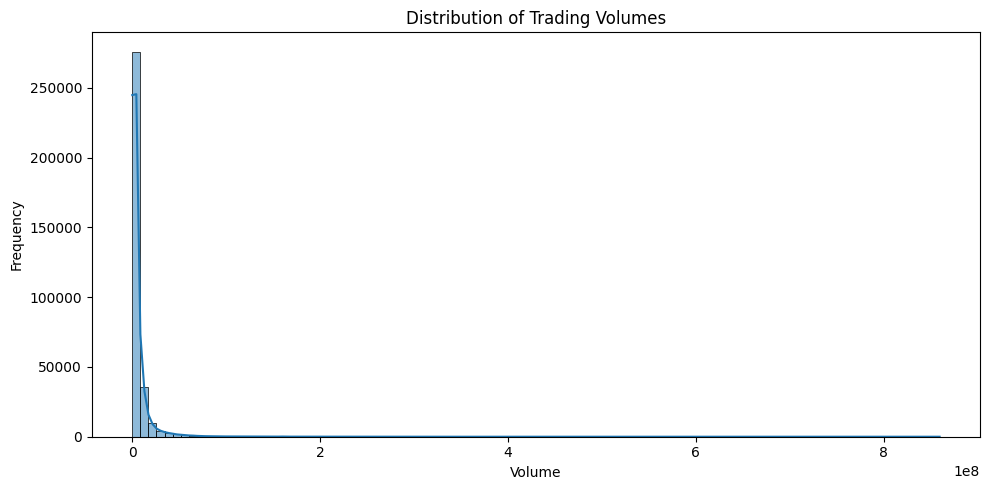

In [29]:
plt.figure(figsize=(10, 5))
sns.histplot(daily_prices_df["volume"], bins=100, kde=True)
plt.title("Distribution of Trading Volumes")
plt.xlabel("Volume")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

### ***'daily_adjusted_prices' Table***
Same as prices, but there have been added adjustments for splits.

In [30]:
eda(daily_adjusted_prices_df, 'daily_adjusted_prices')


 ----EDA for 'daily_adjusted_prices'----
Shape : (340901, 7)
Columns : ['date', 'symbol', 'open', 'close', 'low', 'high', 'volume']

Data types :
 date       object
symbol     object
open      float64
close     float64
low       float64
high      float64
volume    float64
dtype: object

Missing values : date      0
symbol    0
open      0
close     0
low       0
high      0
volume    1
dtype: int64

Number of Duplicates :  0


Stocks with potential splits: ['A' 'AAPL' 'ABT' 'ADP' 'ALK' 'ALXN' 'AME' 'APD' 'APH' 'ARNC']


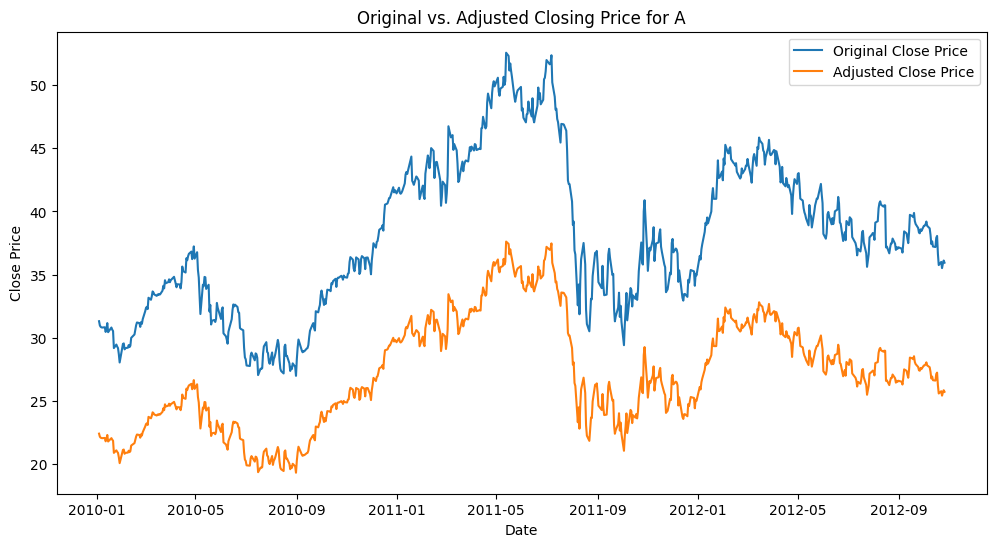

In [ ]:
# Check where original close price is different from adjusted close price
merged_df = pd.merge(daily_prices_df, daily_adjusted_prices_df, on=['date', 'symbol'], suffixes=('_original', '_adjusted'))

# Find symbols where original and adjusted close prices are different
split_symbols = merged_df[merged_df['close_original'] != merged_df['close_adjusted']]['symbol'].unique()

sample_stock_with_split = split_symbols[0] # Select a stock with splits (using the first one from the identified list)
sample_stock_df = merged_df[merged_df['symbol'] == sample_stock_with_split].copy() # Filter the merged dataframe for the selected stock
sample_stock_df['date'] = pd.to_datetime(sample_stock_df['date']) # 'date' column to datetime objects

# Original vs Adjusted Closing Price
plt.figure(figsize=(12, 6))
plt.plot(sample_stock_df['date'], sample_stock_df['close_original'], label='Original Close Price')
plt.plot(sample_stock_df['date'], sample_stock_df['close_adjusted'], label='Adjusted Close Price')
plt.title(f'Original vs. Adjusted Closing Price for {sample_stock_with_split}')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

* **Split-adjusted prices** are **lower** after split events but **maintain the same percentage trends.**
* Gaps between lines indicate split events (e.g., AAPL’s 4:1 split in 2020).

### ***'securities' Table***
General description of each company with division on sectors

In [32]:
eda(securities_df, 'securities')


 ----EDA for 'securities'----
Shape : (505, 8)
Columns : ['Ticker symbol', 'Security', 'SEC filings', 'GICS Sector', 'GICS Sub Industry', 'Address of Headquarters', 'Date first added', 'CIK']

Data types :
 Ticker symbol              object
Security                   object
SEC filings                object
GICS Sector                object
GICS Sub Industry          object
Address of Headquarters    object
Date first added           object
CIK                         int64
dtype: object

Missing values : Ticker symbol              0
Security                   0
SEC filings                0
GICS Sector                0
GICS Sub Industry          0
Address of Headquarters    0
Date first added           0
CIK                        0
dtype: int64

Number of Duplicates :  0


/tmp/ipython-input-33-3658246878.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sector_counts.values, y=sector_counts.index, palette="viridis")


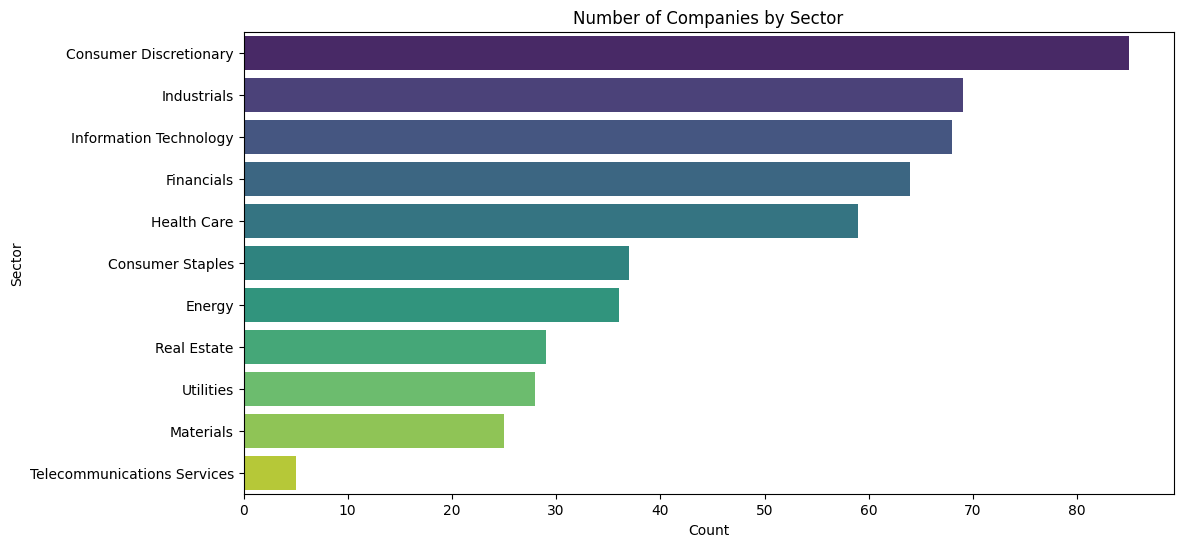

In [33]:
# Bar plot showing the Companies per sector
plt.figure(figsize=(12,6))
sector_counts = securities_df['GICS Sector'].value_counts()
sns.barplot(x=sector_counts.values, y=sector_counts.index, palette="viridis")
plt.title('Number of Companies by Sector')
plt.xlabel('Count')
plt.ylabel('Sector')
plt.show()

* Most companies are clustered into IT/Financials and Healthcare.
* Some sectors like Materials or Telecom Services have fewer representation.

### ***'fundamentals' Table***
Metrics extracted from annual SEC 10K fillings (2012-2016).

In [34]:
eda(fundamentals_df, 'fundamentals')


 ----EDA for 'fundamentals'----
Shape : (1781, 79)
Columns : ['Unnamed: 0', 'Ticker Symbol', 'Period Ending', 'Accounts Payable', 'Accounts Receivable', "Add'l income/expense items", 'After Tax ROE', 'Capital Expenditures', 'Capital Surplus', 'Cash Ratio', 'Cash and Cash Equivalents', 'Changes in Inventories', 'Common Stocks', 'Cost of Revenue', 'Current Ratio', 'Deferred Asset Charges', 'Deferred Liability Charges', 'Depreciation', 'Earnings Before Interest and Tax', 'Earnings Before Tax', 'Effect of Exchange Rate', 'Equity Earnings/Loss Unconsolidated Subsidiary', 'Fixed Assets', 'Goodwill', 'Gross Margin', 'Gross Profit', 'Income Tax', 'Intangible Assets', 'Interest Expense', 'Inventory', 'Investments', 'Liabilities', 'Long-Term Debt', 'Long-Term Investments', 'Minority Interest', 'Misc. Stocks', 'Net Borrowings', 'Net Cash Flow', 'Net Cash Flow-Operating', 'Net Cash Flows-Financing', 'Net Cash Flows-Investing', 'Net Income', 'Net Income Adjustments', 'Net Income Applicable to Comm

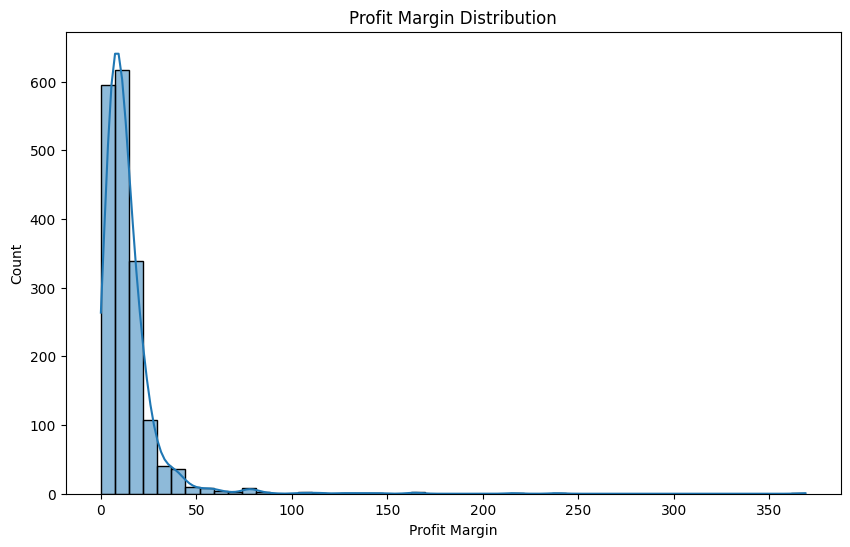

In [35]:
#Profit Margin Distribution
plt.figure(figsize=(10,6))
sns.histplot(fundamentals_df['Profit Margin'].dropna(), bins=50, kde=True)
plt.title('Profit Margin Distribution')
plt.show()

 * *Most companies having profit margins clustered between 0% and 20%. There are a few extreme outliers with very high profit margins.*
 * *Most companies operate with modest profit margins, and only a handful achieve exceptionally high profitability.*

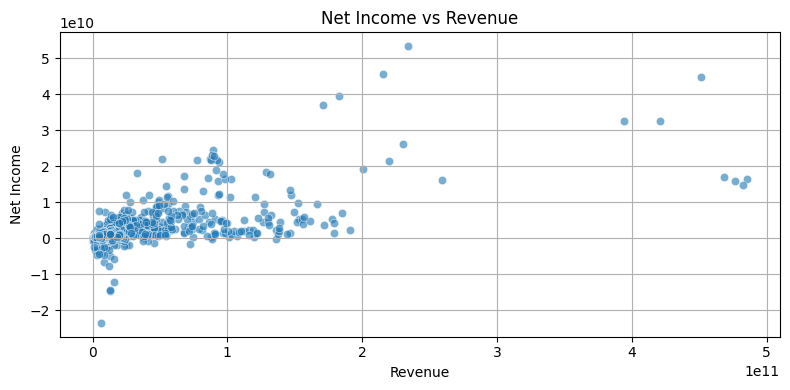

In [36]:
# Profitability Ratios (Net Income vs Revenue)
plt.figure(figsize=(8, 4))
sns.scatterplot(
    data=fundamentals_df,
    x="Total Revenue",
    y="Net Income",
    alpha=0.6
)
plt.title("Net Income vs Revenue")
plt.xlabel("Revenue")
plt.ylabel("Net Income")
plt.grid(True)
plt.tight_layout()
plt.show()

* *There is a positive correlation between revenue and net income—companies with higher revenues generally have higher net incomes.*
* *While scale generally helps profitability, some large companies still report losses, highlighting the importance of cost control and business efficiency.*

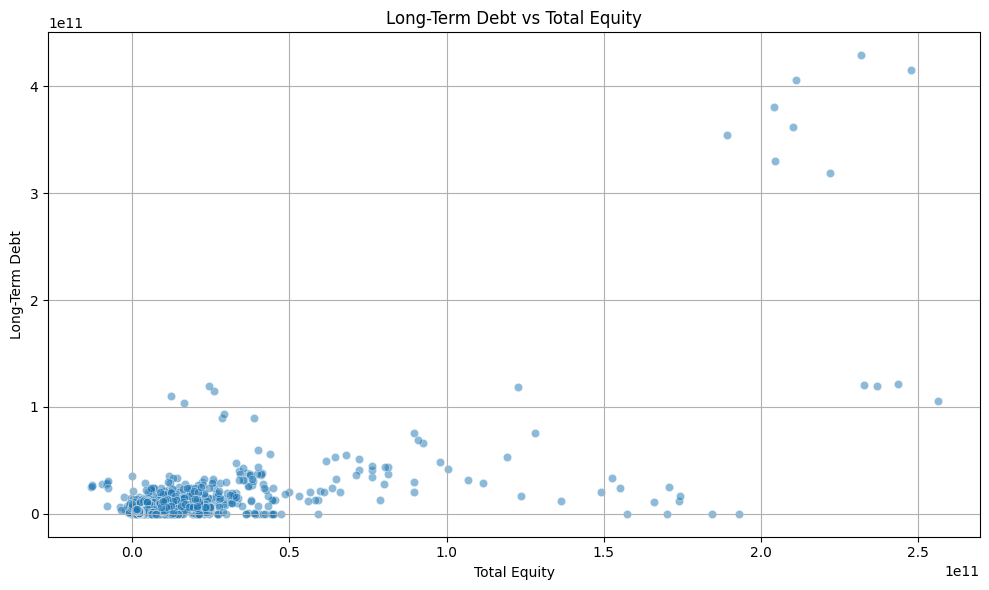

In [37]:
# Capital Structure (Equity vs Debt)
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=fundamentals_df,
    x="Total Equity",
    y="Long-Term Debt",
    alpha=0.5
)
plt.title("Long-Term Debt vs Total Equity")
plt.xlabel("Total Equity")
plt.ylabel("Long-Term Debt")
plt.grid(True)
plt.tight_layout()
plt.show()

* *Most companies cluster at lower values of both long-term debt and total equity. Few have high values of both.*
* *Capital structure varies widely. Some large firms leverage significant debt, possibly to finance growth or acquisitions, while others maintain low leverage.*

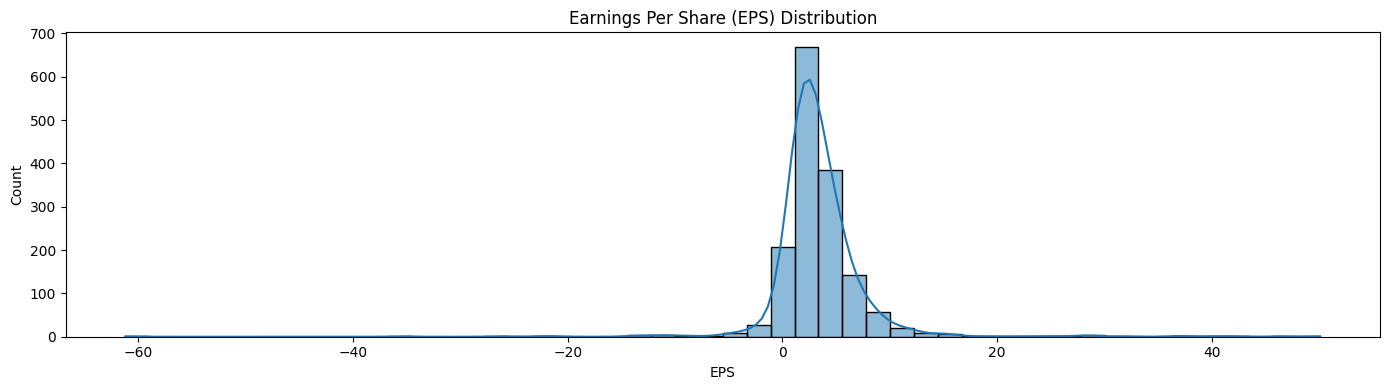

In [38]:
# EPS (Earnings Per Share) Distribution
plt.figure(figsize=(14, 4))
sns.histplot(fundamentals_df["Earnings Per Share"].dropna(), bins=50, kde=True)
plt.title("Earnings Per Share (EPS) Distribution")
plt.xlabel("EPS")
plt.tight_layout()
plt.show()

* *The majority of companies have modest earnings per share, but significant outliers exist—some firms are highly profitable per share, while others are deeply unprofitable.*

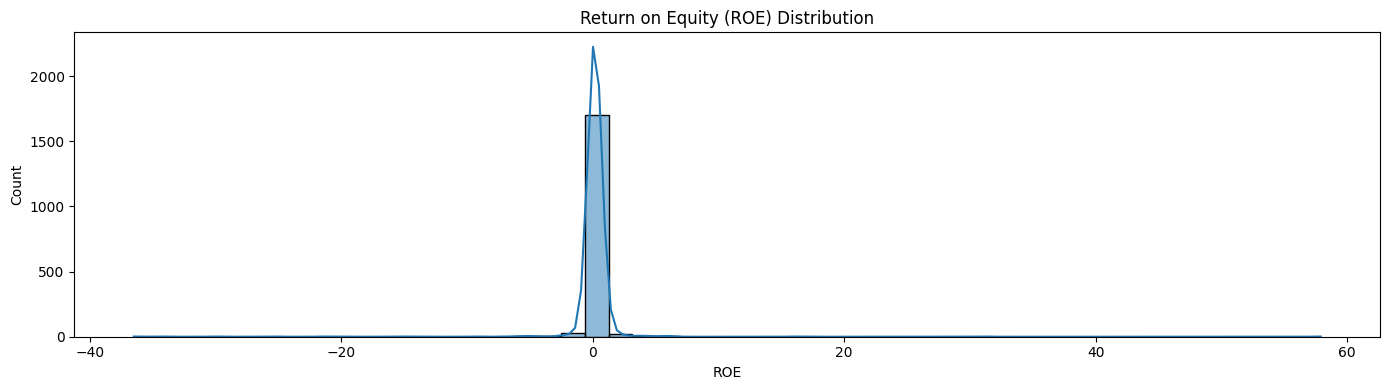

In [39]:
# ROE (Return on Equity)
# ROE = Net Income / Equity
fundamentals_df["roe_calc"] = fundamentals_df["Net Income"] / fundamentals_df["Total Equity"]
fundamentals_df["roe_calc"] = fundamentals_df["roe_calc"].replace([np.inf, -np.inf], np.nan)
plt.figure(figsize=(14, 4))
sns.histplot(fundamentals_df["roe_calc"].dropna(), bins=50, kde=True)
plt.title("Return on Equity (ROE) Distribution")
plt.xlabel("ROE")
plt.tight_layout()
plt.show()

* *The distribution is highly concentrated around ROE ≈ 0%, meaning they are neither significantly profitable nor significantly unprofitable in terms of shareholder equity returns.*
* *Investors must be cautious about a minority with either highly positive or highly negative performance.*

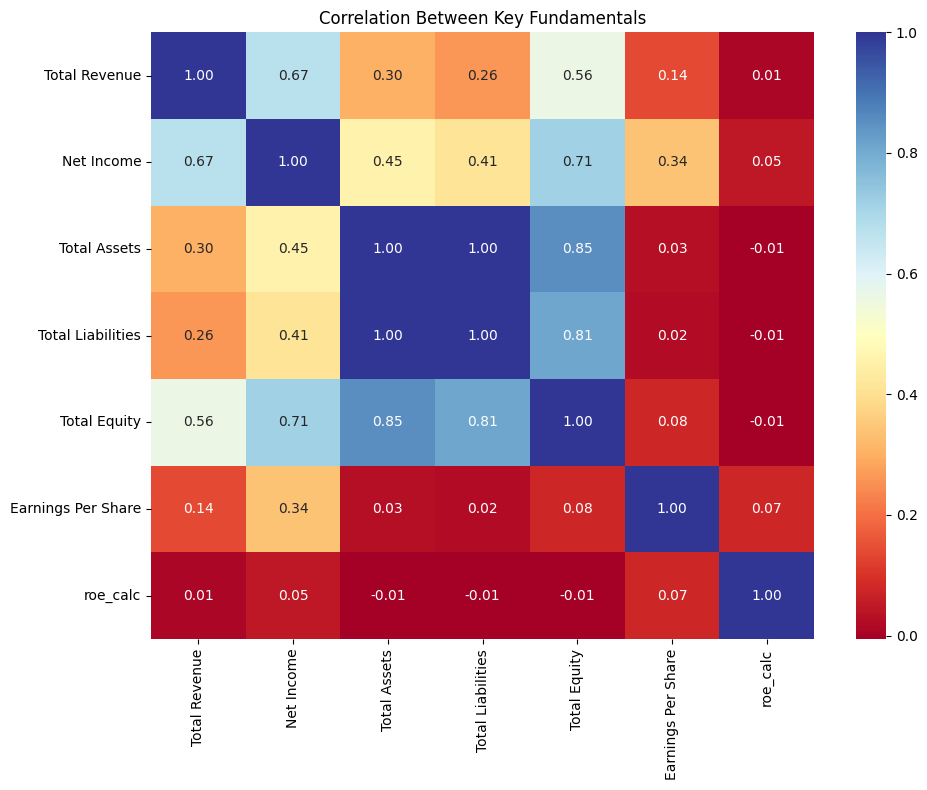

In [40]:
# Feature Correlation Heatmap
cols = ["Total Revenue", "Net Income", "Total Assets", "Total Liabilities", "Total Equity", "Earnings Per Share", "roe_calc"]
selected = fundamentals_df[cols].copy().dropna()
corr = selected.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="RdYlBu", fmt=".2f")
plt.title("Correlation Between Key Fundamentals")
plt.tight_layout()
plt.show()

# ***Data Cleaning***

In [ ]:
# securities_df
securities_df.columns = securities_df.columns.str.lower().str.replace(" ", "_") # Rename columns
securities_df.drop_duplicates(inplace=True) # Remove Duplicates
securities_clean = securities_df.drop(columns=["sec_filings", "cik"], errors="ignore") # Drop unnecessary columns
securities_clean = securities_clean.dropna(subset=["ticker_symbol", "security", "gics_sector"]) # Remove nulls
securities_clean.to_csv("/data/processed/securities_clean.csv", index=False) 

In [ ]:
# daily_prices_df
daily_prices_df.columns = daily_prices_df.columns.str.lower() # Rename columns
daily_prices_clean = daily_prices_df.dropna(subset=["symbol", "date", "close"]) # Drop rows with null prices or symbols
daily_prices_clean = daily_prices_clean.drop_duplicates() # Remove duplicates
daily_prices_clean["date"] = pd.to_datetime(daily_prices_clean["date"], format='mixed') # Convert date column to datetime
daily_prices_clean.to_csv("/data/processed/daily_prices_clean.csv", index=False) 

In [ ]:
# daily_adjusted_prices_df
# Rename and clean similar to prices
daily_adjusted_prices_df.columns = daily_adjusted_prices_df.columns.str.lower()
daily_adjusted_prices_clean = daily_adjusted_prices_df.dropna(subset=["symbol", "date", "close"])
daily_adjusted_prices_clean = daily_adjusted_prices_clean.drop_duplicates()
daily_adjusted_prices_clean["date"] = pd.to_datetime(daily_adjusted_prices_clean["date"], format='mixed')
daily_adjusted_prices_clean.to_csv("/data/processed/daily_adjusted_prices_clean.csv", index=False)

In [ ]:
# fundamentals
fundamentals_df.columns = fundamentals_df.columns.str.lower().str.replace(" ", "_").str.replace("/", "_").str.replace("-", "_") # Clean column names
fundamentals_df = fundamentals_df.loc[:, ~fundamentals_df.columns.str.contains("unnamed")]
fundamentals_df["period_ending"] = pd.to_datetime(fundamentals_df["period_ending"], errors="coerce") # Convert date column
fundamentals_clean = fundamentals_df.dropna(subset=["ticker_symbol", "total_assets", "net_income"]) # Drop rows missing key financials
fundamentals_clean = fundamentals_clean.drop_duplicates() #Remove duplicates
fundamentals_clean.to_csv("/data/processed/fundamentals_clean.csv", index=False) 

/tmp/ipython-input-44-4283272309.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fundamentals_df["period_ending"] = pd.to_datetime(fundamentals_df["period_ending"], errors="coerce") # Convert date column
/tmp/ipython-input-44-4283272309.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fundamentals_df.drop_duplicates(inplace=True) #Remove duplicates
